In [1]:
import pycbc.noise
import pycbc.psd
import pycbc.filter
import pylab
from pycbc.filter import sigma
from pycbc.waveform import get_td_waveform
from pycbc.types.timeseries import load_timeseries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import uniform, randint
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split

#import false signal functions
from ipynb.fs.full.falsig_functions import random_false_sig, flip_gw
from ipynb.fs.full.data_functions import noise, burried_gw, burried_false, burried_flip, visualize,bol, empty_gaussian

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


Trial 2 information:
- SNR 1000
- signals fully contained in windows of 1 second
- masses randomly generated (ranges for masses shown below)
- train and test generated in one batch. Then separate.

data size
- 5781, around (50% positive)
Train-test size:
- 15% test

The following range guarentees that the whole waveform < around 0.8 so that it fits in the window.)

SCHEME:
- 75-100 and 10-100
- 70-75 and 12-75
- 65-70 and 14-70
- 55-65 and 16-65 
- 50-55 and 18-55
- 45-50 and 20-50
- 40-45 and 24-45
- 35-40 and 28-40
- 30-35 and 30-35

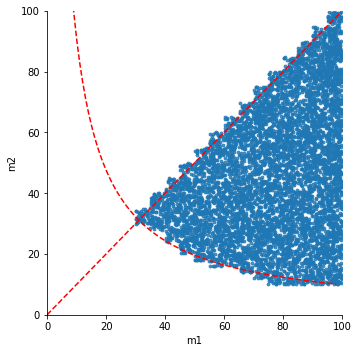

In [2]:
# Randomly generate masses 
# Training masses 
mass = []
for i in np.arange(2):   # repeat process twice for data
    for u in np.arange(95,101):
        for l in np.arange(10,101):
            mass.append([uniform(95,100),uniform(10,100)])
    for u in np.arange(90,95):
        for l in np.arange(10,95):
            mass.append([uniform(90,95),uniform(10,95)])
    for u in np.arange(85,90):
        for l in np.arange(10,90):
            mass.append([uniform(85,90),uniform(10,90)])
    for u in np.arange(80,85):
        for l in np.arange(10,85):
            mass.append([uniform(80,85),uniform(10,85)])
    for u in np.arange(75,80):
        for l in np.arange(10,80):
            mass.append([uniform(75,80),uniform(10,80)])
    for u in np.arange(70,75):
        for l in np.arange(12,75):
            mass.append([uniform(70,75),uniform(12,75)])
    for u in np.arange(65,70):
        for l in np.arange(14,70):
            mass.append([uniform(65,70),uniform(14,70)])
    for u in np.arange(60,65):
        for l in np.arange(16,65):
            mass.append([uniform(60,65),uniform(16,65)])
    for u in np.arange(55,60):
        for l in np.arange(16,60):
            mass.append([uniform(55,60),uniform(16,60)])
    for u in np.arange(50,55):
        for l in np.arange(18,55):
            mass.append([uniform(50,55),uniform(18,55)])
    for u in np.arange(45,50):
        for l in np.arange(20,50):
            mass.append([uniform(45,50),uniform(20,50)])
    for u in np.arange(40,45):
        for l in np.arange(24,45):
            mass.append([uniform(40,45),uniform(24,45)])
    for u in np.arange(35,40):
        for l in np.arange(28,40):
            mass.append([uniform(35,40),uniform(28,40)])
    for u in np.arange(30,35):
        for l in np.arange(30,35):
            mass.append([uniform(30,35),uniform(30,35)])

mass = pd.DataFrame(mass)
mass.columns = ['m1','m2']

# Create scatterplot of dataframe
sns.lmplot('m1', 'm2', data=mass, fit_reg=False, 
           scatter_kws={"s": 8})
plt.ylim(0,100)
plt.xlim(0,100)

plt.plot(np.arange(100),'r--')
plt.plot(1000/np.arange(1,100),'r--')
plt.show()

Unexpected finding: for length to be less than around 0.8, we have the range of masses constrained by the above 2 functions!

In [3]:
# constants and variables
snr = 1000
mag = -21   # for false signals. Try to be close to the amplitude of gw signals
select1 = bol(2,len(mass))
select2 = bol(2,1600)

In [4]:
def appendXy(wave,target):
    wave.save('temporary2.txt')
    wave = np.loadtxt('temporary2.txt',usecols=1)
    X.append(wave)
    y.append(target)

In [5]:
X = []
y = []
# Generate true cases that contain gw, classification label 1.

for i in tqdm(range(len(mass))):
    gww = burried_gw(mass.loc[i,'m1'], mass.loc[i,'m2'], snr)
    appendXy(gww,1)
    
    # Insert false flipped case as well as empty gaussian after every 5 true cases
    if select1[i]:
        wf = burried_flip(mass.loc[i,'m1'], mass.loc[i,'m2'], snr)
        appendXy(wf,0)
        
        wf = noise(gww,snr)
        appendXy(wf,0)

100%|██████████| 7362/7362 [30:03<00:00,  3.12it/s]  


In [6]:
# Generate more data with empty gaussian on varying magitudes
for i in tqdm(range(700)):
    wf = empty_gaussian(uniform(0,30))
    appendXy(wf,0)
    
    wf = empty_gaussian(1.0/uniform(0,30))
    appendXy(wf,0)
    
# Generate false data with false signals on similar magnitude as gw signals
# insert signals on magnitude -20 and -22 after every 5 signals on magnitude -21
'''
for i in tqdm(range(1300)):
    wf = burried_false(mag,snr)
    appendXy(wf,0)
    
    if select2[i]:
        wf = burried_false(mag+1,snr)
        appendXy(wf,0)
        
        wf = burried_false(mag-1,snr)
        appendXy(wf,0)
'''

100%|██████████| 400/400 [01:21<00:00,  5.56it/s]


'\nfor i in tqdm(range(1300)):\n    wf = burried_false(mag,snr)\n    appendXy(wf,0)\n    \n    if select2[i]:\n        wf = burried_false(mag+1,snr)\n        appendXy(wf,0)\n        \n        wf = burried_false(mag-1,snr)\n        appendXy(wf,0)\n'

In [7]:
# Save as dataframe
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

In [15]:
# Since sklearn makes things a lot easier, can just store the whole data and split every time. 
# If want to recreate the split just use same random seed

# '''ALREADY DONE NO NEED REPEAT
f_path = '/Users/DRRRR/Desktop/pyCBC/training_data/trail3/X.txt'
X_df.to_csv(f_path)
f_path = '/Users/DRRRR/Desktop/pyCBC/training_data/trail3/y.txt'
y_df.to_csv(f_path) 
#'''

In [16]:
# statistic information
print("Number of data: ",len(X))

pos = 0
for i in np.arange(len(X)):
    pos += y[i]

print("Percentage ",100* pos/len(X), "% of data contains gw wave.")

Number of data:  13070
Percentage  56.327467482785 % of data contains gw wave.
